# **Content**:

 -  3 [Data Preprocessing](#data)
 -  5 [Modelling](#modelling)
   - 5.1 [Fundamentals of Support Vector Regression (SVR)](#svr)
   - 5.2 [Model Building, Validation and Comparison](#build)

In [19]:
from sklearn.base import BaseEstimator
from sklearn.svm import SVR
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import FeatureUnion
from IPython import get_ipython
from IPython.display import display, HTML

from sklearn.linear_model import LinearRegression
from sklearn.base import TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR

import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# **3 Data Preprocessing** <a class="anchor" id="data"></a>
Here is the data preprocessing and feature selection part, which is exactly the same with the other file. I added it here to use the original data to get the result rather than the intermediate data.

In [20]:
train_data = pd.read_csv('../Data_preprocess/X_train.csv')
test_data=pd.read_csv('../Data_preprocess/X_test.csv')
y_data=pd.read_csv('../Data_preprocess/y_train.csv')
train_weights_daily_df=pd.read_csv('../Data_preprocess/train_weights.csv')['weight']

In [21]:
num_features_final = ['Feature_2', 'Feature_3', 'Feature_4', 'Feature_6',
                      'Feature_11', 'Feature_14',
                      'Feature_17', 'Feature_18', 'Feature_19',
                      'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25',
                      'Ret_MinusTwo', 'Ret_MinusOne', 'R_Agg', 'R_Agg_Std',
                      'R_Std']

cat_features_ordinal_final = ['Feature_13']

cat_features_nominal_final = ['Feature_1', 'Feature_5', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',
                              'Feature_12', 'Feature_15', 'Feature_16', 'Feature_20']

targets = ['Ret_PlusOne', 'Ret_PlusTwo'] #Y里的变量

cat_features_final = cat_features_ordinal_final + cat_features_nominal_final
features_final = num_features_final + cat_features_final

train_X_data = train_data[features_final]
test_X_data = test_data[features_final]

features_targets=features_final+targets
train_Y_data=y_data[targets]

In [22]:
imputer = SimpleImputer(strategy='constant')
train_X_data = pd.DataFrame(imputer.fit_transform(train_X_data), columns=features_final)
test_X_data = pd.DataFrame(imputer.transform(test_X_data), columns=features_final)

#对num数据进行正态变换
num_transformer = QuantileTransformer(n_quantiles=300, output_distribution='normal', random_state=0)

#对分类数据进行PCA处理
# Preprocessing for nominal categorical data
cat_transformer_nominal = Pipeline(steps=[
    ('pca', PCA(n_components=2,random_state=0)),
     ('norm', Normalizer(norm='l2')),
])

# Combined preprocessing for numerical and categorical data
preprocessor_X = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features_final),        
        ('cat_nom', cat_transformer_nominal, cat_features_nominal_final),      
    ])

trans_X_data=pd.DataFrame(preprocessor_X.fit_transform(train_X_data),columns=num_features_final+['pca1','pca2'])
test_X_data=pd.DataFrame(preprocessor_X.transform(test_X_data),columns=num_features_final+['pca1','pca2'])

# **5.Modelling** <a class="anchor" id="modelling"></a>

## **5.1 Fundamentals of Support Vector Regression (SVR)** <a class="anchor" id="svr"></a>

 We will focus on LinearSVR regression, as this method seems to deals particullary well with data with a very low Signal-to-noise ratio as one would expect from financial data. It is also a very fast algorithm with liblinear. For comparison purposes, we also run a LinearRegression model.
 We will do a grid search in the 2 key parameters, epsilon and C, which is related to the tube's width and regularization. 

 In consistency of the competition, we should optimize using a loss function suitable for optimizing Weighed Mean Absolute Error.

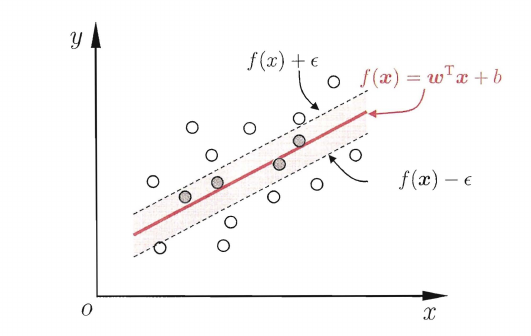

In [23]:
from IPython.display import Image
Image(filename='../Images/1.png',width=500)

 Unlike linear regression, we don't consider the loss caused by data within the tube, i.e. our loss fuction can be written as follows

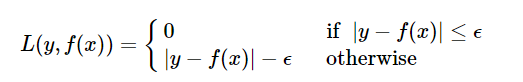

In [24]:
Image(filename='../Images/2.png',width=500)

 Similarly done in SVM, introducing the relaxation variable ξ>0, which allows some samples to fall outside the tube, makes the model more robust.

 Since the absolute value used here is actually two inequalities, that is to say, both sides need relax variables, we define them as ξ∨i, ξ∧i, so the optimization goal becomes:

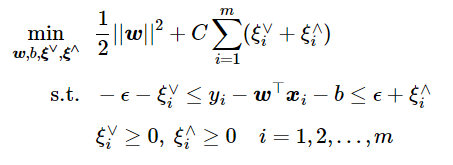

In [25]:
Image(filename='../Images/3.png',width=500)

 The C and ϵ in the above equation correspond to the parameters C and epsilon in LinearSVR, respectively. 
 
 The larger C is, there will be greater penalty for outliers, and eventually fewer points will cross the separation boundary.The model also becomes complicated.The smaller C is, there will be more points crossing the boundary, and the resulting model will be smoother.
 
 The larger the epsilon, the higher the tolerance to outliers, and the final model will also be smoother. This parameter is unique in the svr problem.
 
 See: https://www.cnblogs.com/massquantity/p/11419971.html for more details.

## **5.2 Model Building, Validation and Comparison** <a class="anchor" id="build"></a>

The following is comparison of models and parameter tuning by grid search.

To be consistent with the competition's requirement, we use weighted mean absolute error (WMAE) to evaluate the model performance. It's calculated by firstly take the difference of the predicted value and test set, then take weighted average with prediction weight given by the competition dataset. Models with lower WMAE is better.

Additionally, the baseline model mentioned below is just simply take the average of the given values to predict future values. Once we get a result with lower WMAE than the baseline model, we can say that we have exploit something useful to predict future returns.

In [26]:
#Defining the function of error calculation: weighted mean absolute error
def WA(a, axis, weight):
    a = np.asanyarray(a)
    wgt = np.asanyarray(weight)
    wgt = np.broadcast_to(wgt, (a.ndim-1)*(1,) + wgt.shape)
    wgt = wgt.swapaxes(-1, axis)
    n = len(a)
    avg = np.multiply(a, wgt).sum(axis)/n

    return avg

def WMAE(y_true, y_pred, sample_weight):
    output_errors = WA(np.abs(y_pred - y_true), weight=sample_weight, axis=0)
    avg = np.average(output_errors)

    return avg

#Y variable also needs to be transformed
preprocessor_Y = Pipeline(steps=[
    ('quantile', QuantileTransformer(n_quantiles=300, output_distribution='normal', random_state=0))
])

In [27]:
print('Building model...')

# Define initial model
model = LinearSVR(epsilon=0.03, C=0.0001, loss='squared_epsilon_insensitive', random_state=0)

# Define model pipeline for multi output regression (2days return)
multi_out_reg = MultiOutputRegressor(model)
model_pipeline = Pipeline(steps=[('multioutreg', multi_out_reg)])
estimator = TransformedTargetRegressor(regressor=model_pipeline,transformer=preprocessor_Y)

estimator.fit(trans_X_data, train_Y_data)
best_estimator=estimator

# Predict on train and validation data
pred_train_Y = best_estimator.predict(trans_X_data)

# Evaluate predictions on train and validation data and compare with baseline mean prediction
mean_Y = [0, 0]
mean_Y[0] = y_data[targets[0]].mean()
mean_Y[1] = y_data[targets[1]].mean()

train_mae = WMAE(train_Y_data, pred_train_Y, sample_weight=train_weights_daily_df)
mean_Y_np = np.concatenate((np.full((train_Y_data.shape[0], 1), mean_Y[0]), np.full(
    (train_Y_data.shape[0], 1), mean_Y[1])), axis=1)
mean_mae = WMAE(train_Y_data, mean_Y_np, sample_weight=train_weights_daily_df)

# Print scores
print('WMAE score: LOWER is BETTER;)')
print(f'WMAE of fitted model: {train_mae}')
print(f'WMAE of baseline model: {mean_mae}')

Building model...
WMAE score: LOWER is BETTER;)
WMAE of fitted model: 27817.332622614078
WMAE of baseline model: 27837.43692155248


In [28]:
#We used LinearRegression to see if SVR out-performs simple linear regression

print('Building model...')

# Define initial model
model = LinearRegression()

# Define model pipeline for multi output regression
multi_out_reg = MultiOutputRegressor(model)
model_pipeline = Pipeline(steps=[('multioutreg', multi_out_reg)]) #Preprocessing has been done
estimator = TransformedTargetRegressor(regressor=model_pipeline, transformer=preprocessor_Y)

estimator.fit(trans_X_data, train_Y_data)
best_estimator = estimator
print('Done building model')

pred_train_Y = best_estimator.predict(trans_X_data)

# Evaluate predictions on train and validation data and compare with baseline mean prediction
mean_Y = [0, 0]
mean_Y[0] = y_data[targets[0]].mean()
mean_Y[1] = y_data[targets[1]].mean()

train_mae = WMAE(train_Y_data, pred_train_Y, sample_weight=train_weights_daily_df)
mean_Y_np = np.concatenate((np.full((train_Y_data.shape[0], 1), mean_Y[0]), np.full(
    (train_Y_data.shape[0], 1), mean_Y[1])), axis=1)
mean_mae = WMAE(train_Y_data, mean_Y_np, sample_weight=train_weights_daily_df)

# Print scores

print('WMAE score: LOWER is BETTER;)')
print(f'WMAE of fitted model: {train_mae}')
print(f'WMAE of baseline model: {mean_mae}')

# Predict on test data
pred_test_Y = best_estimator.predict(test_X_data)

Building model...
Done building model
WMAE score: LOWER is BETTER;)
WMAE of fitted model: 27817.354408936073
WMAE of baseline model: 27837.43692155248


Obseving that LinearSVR out-performs LinearRegression, we want to see if we can get the best parameters by gridsearch for LinearSVR to achieve a even better predicting result.

In [29]:
GRIDSEARCH = True

In [30]:
print('Building model...')

# Define initial model
model = LinearSVR(epsilon=0.0, C=0.0005, loss='squared_epsilon_insensitive', random_state=0,max_iter=10000)

# Define model pipeline for multi output regression
multi_out_reg = MultiOutputRegressor(model)
model_pipeline = Pipeline(steps=[('multioutreg', multi_out_reg)]) #Preprocessing has been done
estimator = TransformedTargetRegressor(regressor=model_pipeline, transformer=preprocessor_Y)

if GRIDSEARCH:
    # Define grid parameters to search
    grid_params = [{
        'regressor__multioutreg__estimator__C': [0.00001, 0.00005, 0.0001,0.0005, 0.001],
        'regressor__multioutreg__estimator__epsilon': [0, 0.001, 0.005, 0.01,0.05, 0.1],
        'regressor__multioutreg__estimator__loss': ['squared_epsilon_insensitive']},
        {
        'regressor__multioutreg__estimator__C': [0.00001, 0.00005, 0.0001,0.0005, 0.001],
        'regressor__multioutreg__estimator__epsilon': [0, 0.001, 0.005, 0.01,0.05, 0.1],
        'regressor__multioutreg__estimator__loss': ['epsilon_insensitive']  
        }]

    # Define grid search scoring metric
    scoring = 'neg_mean_absolute_error'

    # Define grid search specified scoring and cross-validation generator
    print('Running grid searc CV...')
    gd_sr = GridSearchCV(estimator=estimator,
                         param_grid=grid_params,
                         scoring=scoring,
                         cv=10,
                         #n_jobs=8,
                         refit=True)

    # Apply grid search and get parameters for best result
    gd_sr.fit(trans_X_data, train_Y_data)
    best_params = gd_sr.best_params_
    best_estimator = gd_sr.best_estimator_
    score = -gd_sr.best_score_

    print(f'Best parameters = {gd_sr.best_params_}')
    print(f'Best MAE = {score}')

else:
    estimator.fit(trans_X_data, train_Y_data)
    best_estimator = estimator

print('Done building model')

pred_train_Y = best_estimator.predict(trans_X_data)

# Evaluate predictions on train and validation data and compare with baseline mean prediction
mean_Y = [0, 0]
mean_Y[0] = y_data[targets[0]].mean()
mean_Y[1] = y_data[targets[1]].mean()

train_mae = WMAE(train_Y_data, pred_train_Y, sample_weight=train_weights_daily_df)
mean_Y_np = np.concatenate((np.full((train_Y_data.shape[0], 1), mean_Y[0]), np.full(
    (train_Y_data.shape[0], 1), mean_Y[1])), axis=1)
mean_mae = WMAE(train_Y_data, mean_Y_np, sample_weight=train_weights_daily_df)

# Print scores
print('WMAE score: LOWER is BETTER;)')
print(f'WMAE of fitted model: {train_mae}')
print(f'WMAE of baseline model: {mean_mae}')

# Predict on test data
pred_test_Y = best_estimator.predict(test_X_data)

Building model...
Running grid searc CV...
Best parameters = {'regressor__multioutreg__estimator__C': 0.0001, 'regressor__multioutreg__estimator__epsilon': 0, 'regressor__multioutreg__estimator__loss': 'epsilon_insensitive'}
Best MAE = 0.01551199729171306
Done building model
WMAE score: LOWER is BETTER;)
WMAE of fitted model: 27812.562393518878
WMAE of baseline model: 27837.43692155248


In this section, we see that the WMAE is 27812.5624 (LinearSVR with best parameter) < 27817.3544 (LinearRegression) < 27837.4369 (Baseline model). 

We observe that the model perform better than the baseline model.